# **Related works**
Brain tumour classification using CNN methods is a growing area of research. Many researchers have employed pre-trained models and attempted to add their own improvement. These are some of the papers we have taken reference from in this project (not exhausive, full list is in the reference section of our report):

**"The DCT-CNN-resnet50 architecture to classify brain tumors with super-resolution, convolutional neural network, and the resnet50" by Deshpande, A., Estrela, V. V., & Patavardhan, P. (2021):**

Deshpande et al. (2021) employed resolution enhancement
techniques (Discrete Cosine Transform-based image fusion)
along with CNN, in order to facilitate more accurate classification between scans of brain tissue with and without
tumour. The paper displays high accuracy of this method,
positioning it as a promising method for brain tumour classification. However, there is a lack of comparison with other
CNN architectures.

**"CNN-based deep learning approach for MRI-based brain tumor detection" by Narayanasamy, K., Elangovan, L, S. K., Maragatharajan, M., & Deepa, D. (2023)**:
Narayanasamy et al. (2023) utilized RMSprop, an optimization algorithm designed to tackle slow convergence in
Stochastic Gradient Descent (SGD). By adaptively scaling
the learning rate for each parameter, RMSprop was combined with Convolutional Neural Networks (CNNs) to enhance model performance. This led to a very high accuracy
level of 99.76%.

The aim of this project is to provide an extension to the available research
on brain tumour classification by:
• Comparing different CNN architectures
• Incorporating additional features such as symmetry into
our model.
• Testing out the effect of having different trainable layers
on model performance

# Code documentation

Check the readme.pdf document on how to run the code.

The code below will be split up into sections and subsections, with each part designed to accomplish a specific task (eg split the dataset into training, validation and test data.)


# 1. Install dependencies

In [38]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Run this to retrive all the brain tumour scans.

In [39]:
# !rm -rf IT1244_data
!git clone https://github.com/ContainerWhale/IT1244_data.git

fatal: destination path 'IT1244_data' already exists and is not an empty directory.


Run this to import Symmetry package, which contain functions that allow us to draw symmetry lines and determine the symmetry metric.

In [40]:
# Download the second Python file from GitHub
!wget https://raw.githubusercontent.com/ContainerWhale/IT1244_data/main/Code/Symmetry.py

import Symmetry

--2024-04-07 09:44:42--  https://raw.githubusercontent.com/ContainerWhale/IT1244_data/main/Code/Symmetry.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10964 (11K) [text/plain]
Saving to: ‘Symmetry.py.1’

Symmetry.py.1       100%[===================>]  10.71K  --.-KB/s    in 0s      

2024-04-07 09:44:43 (84.2 MB/s) - ‘Symmetry.py.1’ saved [10964/10964]



In [41]:
from Symmetry import extractLine

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
from sklearn.model_selection import train_test_split

# 2. Read image files

Imgage converted from BGR to RGB and resized to 128 x 128 to standardise the image size.

In [43]:
yes_path = "/content/IT1244_data/Brain Tumor/data/malignant/*.jpg"
no_path = "/content/IT1244_data/Brain Tumor/data/benign/*.jpg"
size = 128
yes, no = [], []
for f in glob.iglob(yes_path):
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = crop_to_fit(img, 300)
    img = cv2.resize(img, (size, size))
    yes.append(img)

for f in glob.iglob(no_path):
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = crop_to_fit(img, 300)
    img = cv2.resize(img, (size, size))
    no.append(img)





# 3. Split the data

In [44]:
X_img = (yes + no)
y = np.array([1 if i < len(yes) else 0 for i in range(len(yes)+len(no))])

This splits the data into training, validation, and test sets in a 63:27:10 ratio.

In [91]:
seed = 1244
X_tv_img, X_test_img, y_tv, y_test = train_test_split(X_img, y, test_size=0.1, random_state=seed)
X_train_img, X_val_img, y_train, y_val = train_test_split(X_tv_img, y_tv, test_size=0.3, random_state=seed)

# 4. Data processing

## 4a. Feature extraction

Symmetry line is extracted from training, validation and testing images respectively and stored into train_temp, val_temp and test_temp.

In [92]:
train_temp = extractLine(X_train_img)
val_temp = extractLine(X_val_img)
test_temp = extractLine(X_test_img)


Uncomment to draw symmetry line on all images

In [93]:
# X_train_img = train_temp.draw_all()
# X_val_img = val_temp.draw_all()

Symmetry metric is obtained for training, validation and testing images respectively.

In [94]:
X_train_ftr = np.expand_dims(train_temp.get_sym(), axis=1)
X_val_ftr = np.expand_dims(val_temp.get_sym(), axis=1)
X_test_ftr = np.expand_dims(test_temp.get_sym(), axis=1)

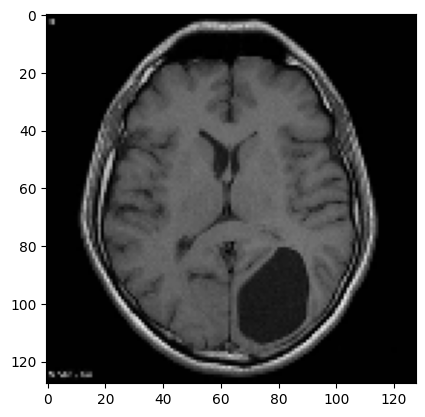

In [95]:
plt.imshow(X_train_img[10])

The following code draws a boxplot of the symmetry metric against the class of image.

{'whiskers': [<matplotlib.lines.Line2D at 0x7b32c5dc3460>,
 'caps': [<matplotlib.lines.Line2D at 0x7b32c5dc26b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b32c5dc2500>,
 'medians': [<matplotlib.lines.Line2D at 0x7b32c5ddb8b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7b32c5dd8490>,
 'means': []}

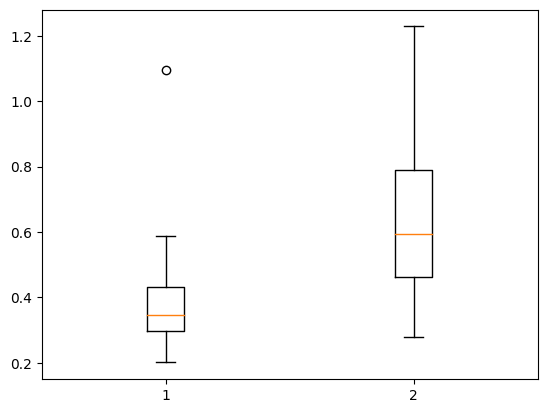

In [96]:
X_train_ftr = np.array(X_train_ftr)
y_train = np.array(y_train)
malignant = X_train_ftr.flatten()[y_train == 1]
benign = X_train_ftr.flatten()[y_train == 0]
plt.boxplot([benign, malignant])

## 4b. Augmentation

We define random inversion in the following code. Inversion involves subtracting each pixel value from 255 based on a specified probability p, introducing additional variability to the dataset.

In [97]:
from tensorflow.keras import layers

def random_invert_img(x, p=0.5, seed=None):
    if not (seed is None):
        tf.random.set_seed(seed)
    if tf.random.uniform([]) < p:
        x = (255-x)
    return x

# def random_invert(factor=0.5):
#   return layers.Lambda(lambda x: random_invert_img(x, factor))

# random_invert = random_invert()

class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, seed=None, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor
    self.seed = seed

  def call(self, x):
    return random_invert_img(x, seed)

We applied the following data augmentation techniques:
ntensity level inversion

*   Intensity level inversion
*   Flip operations
*   Random contrast adjustments
*   Random zooms.
*   Random rotation
*   Random brightness level adjustments


In [98]:
data_augmentation = tf.keras.Sequential([
  RandomInvert(),
  layers.RandomContrast(0.4, seed=seed),
  layers.RandomBrightness(0.2, seed=seed),
  layers.RandomFlip("horizontal_and_vertical", seed=seed),
  layers.RandomRotation(0.1, fill_mode="nearest", seed=seed),
  layers.RandomZoom((-0.2, 0.2), fill_mode="nearest", seed=seed),
#   layers.Rescaling(1./255)
])


Can choose to inflate the benign batches to inflate the benign data to even out the dataset (uncomment and comment the necessary code to enable)

In [99]:
batch_mal = 6 # number of new augmented images to be generated per sample for malignant,
# benign batch sizes are inflated accordingly to even out the dataset (uncomment and comment the necessary code to enable)
b, m = sum(y_train == 0), sum(y_train == 1)
# batch_ben = m * (batch_mal + 1) // b - 1 # uncomment this
batch_ben = batch_mal # comment this
print(f"malignant: {batch_mal}\nbenign: {batch_ben}")

X_train_img_aug, X_train_ftr_aug, y_train_aug = [], [], []


for i in range(len(X_train_img)):
    X_train_img_aug.append(X_train_img[i])
    X_train_ftr_aug.append(X_train_ftr[i])
    y_train_aug.append(y_train[i])

    batch = batch_mal if y_train[i] == 1 else batch_ben
    for _ in range(batch):
        new = data_augmentation(X_train_img[i])

        new = np.array(new).astype("uint8")

        X_train_img_aug.append(new)
        X_train_ftr_aug.append(X_train_ftr[i])
        y_train_aug.append(y_train[i])

sum(y_train_aug)/len(y_train_aug)

malignant: 6
benign: 6


0.6597222222222222

Visualisation of augmented images

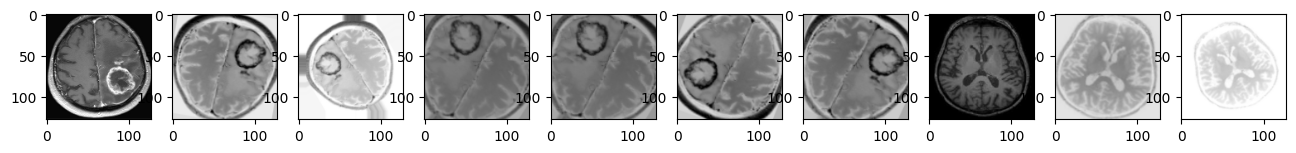

In [100]:
plt.figure(figsize=(16,9))
for i,img in enumerate(X_train_img_aug[:10]):
    plt.subplot(1, 10, i+1)
    plt.imshow(img)

## 4c. Standardisation

In [101]:
def dataset_standardise_img(dataset, mean=None, std=None):
    '''
    dataset: numpy array of shape (N, ...)
    returns standardised values for each observation, numpy array of shape (N, ...) using dataset standardisation
    '''
    if mean and std:
        return (dataset - mean) / std
    dataset = np.array(dataset)
    mean = np.mean(dataset)
    std = np.std(dataset)

    return (dataset - mean) / std, mean, std

def standardise_img(dataset):
    '''
    dataset: numpy array of shape (N, ...)
    returns standardised values for each observation, numpy array of shape (N, ...) using per-image standardisation
    '''
    dataset = np.array(dataset)
    l = len(dataset.shape)
    tup = tuple(range(1,l))
    mean = np.mean(dataset, axis=tup, keepdims=True)
    std = np.std(dataset, axis=tup, keepdims=True)

    return (dataset - mean) / std

def standardise_col(dataset, mean=None, std=None):
    '''
    dataset: numpy array of shape (N, D)
    standardises each column
    returns standardised dataset of shape (N, D)
    '''
    if mean and std:
        return (dataset - mean) / std
    dataset = np.array(dataset)
    mean = np.mean(dataset, axis=0)
    std = np.std(dataset, axis=0)
    return (dataset - mean) / std, mean, std

Comment and uncomment the necessary code to switch between these 3 options:
1.	Normalisation of images
2.	Per-image standardisation of images
3.	Dataset standardisation of images


In [102]:
# Augmentation, normalised
# X_train_img_std = np.array(X_train_img_aug) / 255
# X_val_img_std = np.array(X_val_img) / 255
# X_test_img_std = np.array(X_test_img) / 255
# X_train_ftr_std, mean, std = standardise_col(X_train_ftr_aug)
# X_val_ftr_std = standardise_col(X_val_ftr, mean, std)
# X_test_ftr_std = standardise_col(X_test_ftr, mean, std)
# y_train_std = np.array(y_train_aug)

# Augmentation, per-image standardised
X_train_img_std = standardise_img(X_train_img_aug)
X_val_img_std = standardise_img(X_val_img)
X_test_img_std = standardise_img(X_test_img)
X_train_ftr_std, mean, std = standardise_col(X_train_ftr_aug)
X_val_ftr_std = standardise_col(X_val_ftr, mean, std)
X_test_ftr_std = standardise_col(X_test_ftr, mean, std)
y_train_std = np.array(y_train_aug)

# Augmentation, dataset standardised
# X_train_img_std, mean, std = dataset_standardise_img(X_train_img_aug)
# X_val_img_std = dataset_standardise_img(X_val_img, mean, std)
# X_test_img_std = dataset_standardise_img(X_test_img, mean, std)
# X_train_ftr_std, mean, std = standardise_col(X_train_ftr_aug)
# X_val_ftr_std = standardise_col(X_val_ftr, mean, std)
# X_test_ftr_std = standardise_col(X_test_ftr, mean, std)
# y_train_std = np.array(y_train_aug)


In [103]:
np.max(X_train_img_std)

6.585264626175413

In [104]:
[type(x) for x in (X_train_img_std, X_val_img_std, y_train_std, y_val, X_train_ftr_std, X_val_ftr_std)]

[numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray]

Applying symmetry metric on augmented images (the distinction between malignant and benign becomes worse)

In [105]:
# X_temp = np.array(X_train_img_aug)
# plt.boxplot([get_sym(X_temp[y_train_std == 0]), get_sym(X_temp[y_train_std == 1])])

# 5. The model class

Initialisation of 3 CNN models, VGG16, InceptionResNetV2 and ResNet50. We chose to test these 3 models as they performed better than most models on the ImageNet dataset.

Notice that symmetry metrics were concatenated with other input data in order to capture more pattens in the data.

We also defined fine-tuning in this code (unfreezing certain convolutional layers and training the model again, albeit at a slower learning rate to prevent overfitting).

In [106]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras import layers, models, optimizers
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Dense, Dropout, concatenate, Input, BatchNormalization
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

class CNNModel():
    def __init__(self, model_name,
                 X_train_img, X_val_img,
                 y_train, y_val,
                 X_train_ftr = None, X_val_ftr = None) -> None:

        '''Let there be T training samples and V validation samples and n features
        model_name: name of model as string (e.g. "VGG16", "InceptionResNetV2")
        X_train_img: numpy array of shape (T, 128, 128, 3)
        X_val_img: numpy array of shape (V, 128, 128, 3)
        y_train: numpy array of shape (T,), with binary values
        y_val: numpy array of shape (V,), with binary values
        X_train_ftr: (Optional) numpy array of shape (T, n)
        X_val_ftr: (Optional) numpy array of shape (V, n)
        '''

        self.X_train_img, self.X_val_img = X_train_img, X_val_img
        self.y_train, self.y_val = y_train, y_val
        self.using_ftr = True

        if X_train_ftr is None or X_val_ftr is None:
            self.X_train_ftr = np.empty((X_train_img.shape[0], 0))
            self.X_val_ftr = np.empty((X_val_img.shape[0], 0))
            self.using_ftr = False
            pass
        else:
            self.X_train_ftr = X_train_ftr
            self.X_val_ftr = X_val_ftr

        if model_name == "VGG16":
            self.model = self._create_VGG16_model(X_train_img.shape[1:], self.X_train_ftr.shape[1:])
        elif model_name == "InceptionResNetV2":
            self.model = self._create_InceptionResNetV2_model(X_train_img.shape[1:], self.X_train_ftr.shape[1:])
        elif model_name == "ResNet50":
            self.model = self._create_ResNet50_model(X_train_img.shape[1:], self.X_train_ftr.shape[1:])
        else:
            self.model = None

        self.model_name = model_name
        self.history = None
        self.ft_model = None
        self.ft_history = None
        self.y_pred = None

    ### Models ###
    def _create_VGG16_model(self, image_shape, feature_shape):
        # Defining inputs
        image_input = Input(shape=image_shape, name="image_input")
        feature_input = Input(shape=feature_shape, name='feature_input')

        # Constructing VGG16 model
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)

        #Before fine-tuning, we opted not to train the pre-trained base layers.
        base_model.trainable = False

        out = GlobalMaxPooling2D()(base_model.output)
        out = Dense(64, activation="relu")(out)
        out = Dropout(0.5)(out)
        #Concatenation of image data with symmetry metric.
        out = concatenate([out, feature_input])
        out = Dense(1, activation="sigmoid")(out)

        model = Model(inputs = [image_input, feature_input], outputs = out)

        # model.layers[16].trainable = True
        # model.layers[17].trainable = True
        return model

    def _create_InceptionResNetV2_model(self, image_shape, feature_shape):
        # Defining inputs
        image_input = Input(shape=image_shape, name="image_input")
        feature_input = Input(shape=feature_shape, name='feature_input')

        # Constructing Inception model
        base_model = keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=image_input)
        base_model.trainable = False

        out = GlobalMaxPooling2D()(base_model.output)
        #Concatenation of image data with symmetry metric.
        out = concatenate([out, feature_input])
        out = BatchNormalization()(out)
        out = Dropout(0.6)(out)
        out = Dense(1, activation="sigmoid")(out)

        model = Model(inputs = [image_input, feature_input], outputs = out)

        return model


    def _create_ResNet50_model(self, image_shape, feature_shape):
        # Defining inputs
        image_input = Input(shape=image_shape, name="image_input")
        feature_input = Input(shape=feature_shape, name='feature_input')

        # Constructing resnet50 model
        base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)
        base_model.trainable = False

        out = GlobalMaxPooling2D()(base_model.output)
        out = concatenate([out, feature_input])
        out = BatchNormalization()(out)
        out = Dropout(0.6)(out)
        out = Dense(1, activation="sigmoid")(out)

        model = Model(inputs = [image_input, feature_input], outputs = out)

        return model

    ### End of models ###

    ### Training methods ###
    def get_summary(self):
        if self.model is None:
            print("No model")
            return
        else:
            model = self.model
        print(f"Model input names: {model.input_names}")
        print()
        for i, layer in enumerate(model.layers):
            print(f"{i}\t{layer.__class__.__name__}   \t{layer.trainable}")

    def run_model(self, epochs, batch_size):
        '''
        epochs: epochs
        batch_size: batch_size

        returns history
        '''
        if self.model is None:
            print("No model")
            return

        X_train = {'image_input': self.X_train_img, 'feature_input': self.X_train_ftr}
        X_val = {'image_input': self.X_val_img, 'feature_input': self.X_val_ftr}

        # Compile the model
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        history = self.model.fit(x = X_train, y = self.y_train,
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(X_val, self.y_val))
        self.history = history
        return history

    def fine_tune(self, target_name, epochs, batch_size, l_rate=1e-5):
        '''
        target_name: name of layer to set to trainable and thereafter
        epochs: epochs
        batch_size: batch_size
        l_rate: learning rate, default 1e-5

        returns history
        '''
        from keras.models import clone_model

        if self.model is None:
            print("No model")
            return

        self.ft_model = clone_model(self.model)
        self.ft_model.set_weights(self.model.get_weights())


        set_trainable = False
        for layer in self.ft_model.layers:
            if layer.name == target_name:
                layer.trainable = True
                set_trainable = True
            layer.trainable = True if set_trainable else False

        X_train = {'image_input': self.X_train_img, 'feature_input': self.X_train_ftr}
        X_val = {'image_input': self.X_val_img, 'feature_input': self.X_val_ftr}


        self.ft_model.compile(optimizer=keras.optimizers.Adam(l_rate), loss='binary_crossentropy', metrics=['accuracy'])

        history = self.ft_model.fit(x = X_train, y = self.y_train,
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(X_val, self.y_val))
        self.ft_history = history
        return history

    def fine_tune_again(self, epochs, batch_size, l_rate=1e-5):
        X_train = {'image_input': self.X_train_img, 'feature_input': self.X_train_ftr}
        X_val = {'image_input': self.X_val_img, 'feature_input': self.X_val_ftr}

        self.ft_model.compile(optimizer=keras.optimizers.Adam(l_rate), loss='binary_crossentropy', metrics=['accuracy'])

        history = self.ft_model.fit(x = X_train, y = self.y_train,
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(X_val, self.y_val))

        return history

    def get_model(self):
        return self.model
    ### End of training methods ###


    ### Data Analysis ###
    def _plot_loss_curve(self, history1):
        df = pd.DataFrame(history1.history)

        # History for loss
        ax = df[["loss", "val_loss"]].plot()
        ax.legend(["Training loss", "Testing loss"])
        plt.xlabel("# of epochs")
        plt.ylabel("Loss")
        plt.show()

        # History for accuracy
        ax = df[["accuracy", "val_accuracy"]].plot()
        ax.legend(["Training accuracy", "Testing accuracy"])
        plt.xlabel("# of epochs")
        plt.ylabel("Accuracy")
        plt.show()


    def _show_confusion_matrix(self, model, fancy, test_data):

        if test_data:
            X_val_img = test_data[0]
            X_val_ftr = test_data[1]
            y_val = test_data[2]
        else:
            X_val_img = self.X_val_img
            X_val_ftr = self.X_val_ftr
            y_val = self.y_val

        X_val_img, X_val_ftr = np.array(X_val_img), np.array(X_val_ftr)

        if not self.using_ftr:
            # Run this if not using ftr
            empty = np.empty((X_val_img.shape[0], 0))
            y_pred = model.predict([X_val_img, empty])[:,0]
        else:
            # Run this if using ftr
            y_pred = model.predict([X_val_img, X_val_ftr])[:,0]
        y_pred_classes = (y_pred > 0.5).astype(int)
        cm = confusion_matrix(y_val, y_pred_classes)

        if fancy:
            sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Confusion Matrix')
            plt.show()

        # Print the confusion matrix as a table
        print("Confusion Matrix:")
        print(cm)

        # Accuracy
        acc = (cm[0,0] + cm[1,1]) / np.sum(cm)
        # Miss rate
        miss = (cm[1,0]/np.sum(cm[1,:]))
        #F1 score
        f1 = 2/(1/acc + 1/(1-miss))
        print(acc, miss, f1)
        if test_data is None:
            self.y_pred = y_pred

    def plot_loss_curve(self):
        try:
            print("Training curves")
            self._plot_loss_curve(self.history)
        except:
            print("None")
        try:
            print("Fine tuning curves")
            self._plot_loss_curve(self.ft_history)
        except:
            print("None")

    def show_confusion_matrix(self, fancy=False, test_data=None):
        try:
            print("Before fine tuning set")
            self._show_confusion_matrix(self.model, fancy, test_data)
        except:
            print("None")
        try:
            print("After fine tuning set")
            self._show_confusion_matrix(self.ft_model, fancy, test_data)
        except:
            print("None")


    def show_misclassified(self, X_val_img, show_sym=False):
        '''
        Works for validation set only
        X_val_img: Original rgb validation images
        '''

        if self.y_pred is None:
            print("No predictions")
        X_val_img = np.array(X_val_img)
        # False negatives (miss)
        print("FN")
        indices = (self.y_pred < 0.5) * (self.y_val > 0.5)
        print(f"Indices: {np.where(indices)[0]}")
        FN = X_val_img[indices]
        FN = FN.astype(int)
        if show_sym:
            print(f"Symmetry metric:\n{self.X_val_ftr[indices]}")

        plt.figure(figsize=(16,9))
        for i in range(len(FN)):
            plt.subplot(1, len(FN), i+1)
            plt.title("FN")
            plt.imshow(FN[i])
        plt.show()

        # False positives (false alarm)
        print("FP")
        indices = (self.y_pred > 0.5) * (self.y_val < 0.5)
        print(f"Indices: {np.where(indices)[0]}")
        FP = X_val_img[indices]
        FP = FP.astype(int)
        if show_sym:
            print(f"Symmetry metric:\n{self.X_val_ftr[indices]}")

        plt.figure(figsize=(16,9))
        for i in range(len(FP)):
            plt.subplot(1, len(FP), i+1)
            plt.title("FP")
            plt.imshow(FP[i])
        plt.show()


# 5a. Fitting the model
Comment/Uncomment to initiate/train models

Note: resnet_model_wosym is the model trained without the input of the symmetry metric

In [107]:
# Defining the object
# vgg_model = CNNModel("VGG16", X_train_img_std, X_val_img_std, y_train_std, y_val, X_train_ftr_std, X_val_ftr_std)
# inception_model = CNNModel("InceptionResNetV2", X_train_img_std, X_val_img_std, y_train_std, y_val, X_train_ftr_std, X_val_ftr_std)
resnet_model = CNNModel("ResNet50", X_train_img_std, X_val_img_std, y_train_std, y_val, X_train_ftr_std, X_val_ftr_std)
# resnet_model_wosym = CNNModel("ResNet50", X_train_img_std, X_val_img_std, y_train_std, y_val)

# Get summary
# resnet_model.get_summary()
# resnet_model.model.summary()

# Initial training
# vgg_model.run_model(12, 32)
# inception_model.run_model(10, 32)
resnet_model.run_model(10, 32)
# resnet_model_wosym.run_model(10, 32)

Epoch 1/10
32/32 [==============================] - 6s 72ms/step - loss: 0.7720 - accuracy: 0.6220 - val_loss: 0.5452 - val_accuracy: 0.7778
Epoch 2/10
32/32 [==============================] - 1s 39ms/step - loss: 0.5670 - accuracy: 0.7302 - val_loss: 0.4322 - val_accuracy: 0.8254
Epoch 3/10
32/32 [==============================] - 1s 40ms/step - loss: 0.5280 - accuracy: 0.7500 - val_loss: 0.4033 - val_accuracy: 0.8095
Epoch 4/10
32/32 [==============================] - 1s 38ms/step - loss: 0.4312 - accuracy: 0.8016 - val_loss: 0.3901 - val_accuracy: 0.8254
Epoch 5/10
32/32 [==============================] - 1s 37ms/step - loss: 0.3972 - accuracy: 0.8185 - val_loss: 0.3653 - val_accuracy: 0.8571
Epoch 6/10
32/32 [==============================] - 1s 38ms/step - loss: 0.3783 - accuracy: 0.8224 - val_loss: 0.3721 - val_accuracy: 0.8730
Epoch 7/10
32/32 [==============================] - 1s 40ms/step - loss: 0.3479 - accuracy: 0.8562 - val_loss: 0.3700 - val_accuracy: 0.8571
Epoch 8/10
32

Visualisation of model.summary

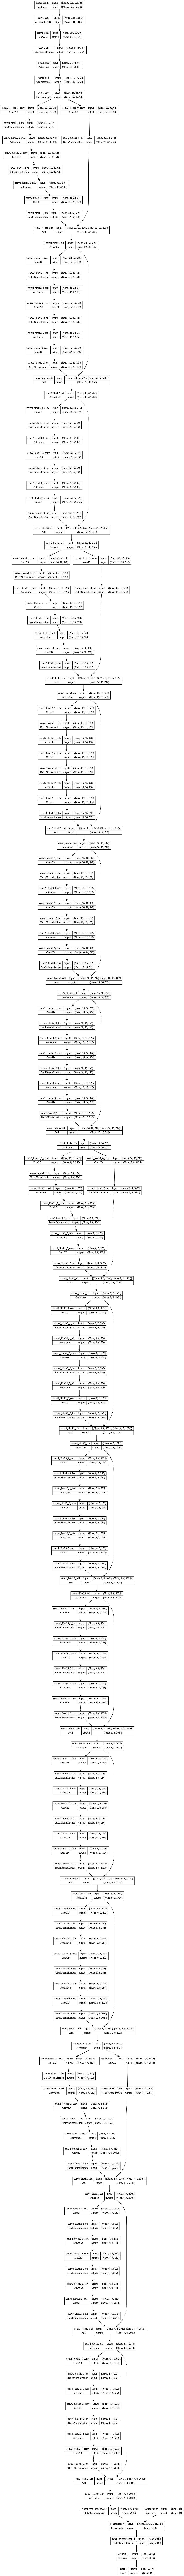

In [108]:
tf.keras.utils.plot_model(resnet_model.model, to_file='last_layers_model_summary.png', show_shapes=True)

#5b. Fine tune

Fitting the model after fine-tuning:

In [109]:
# vgg_model.fine_tune(target_name="block4_conv1", epochs=5, batch_size=16)
# inception_model.fine_tune(target_name="block8_10_mixed", epochs=8, batch_size=32)
resnet_model.fine_tune(target_name="conv4_block1_1_conv", epochs=5, batch_size=32)
# resnet_model_wosym.fine_tune(target_name="conv4_block1_1_conv", epochs=5, batch_size=32)

Epoch 1/5
32/32 [==============================] - 20s 115ms/step - loss: 0.7729 - accuracy: 0.6825 - val_loss: 0.4097 - val_accuracy: 0.8254
Epoch 2/5
32/32 [==============================] - 3s 81ms/step - loss: 0.4913 - accuracy: 0.7986 - val_loss: 0.3918 - val_accuracy: 0.8254
Epoch 3/5
32/32 [==============================] - 3s 81ms/step - loss: 0.2900 - accuracy: 0.8750 - val_loss: 0.3867 - val_accuracy: 0.8095
Epoch 4/5
32/32 [==============================] - 3s 79ms/step - loss: 0.2339 - accuracy: 0.9127 - val_loss: 0.3565 - val_accuracy: 0.8254
Epoch 5/5
32/32 [==============================] - 3s 79ms/step - loss: 0.1740 - accuracy: 0.9266 - val_loss: 0.3309 - val_accuracy: 0.8413


In [110]:
# resnet_model.fine_tune_again(2, 32, l_rate=1e-6)

# 6. Data analysis

Training curves


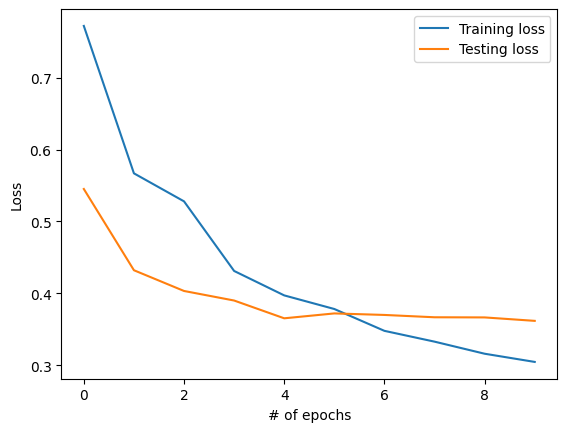

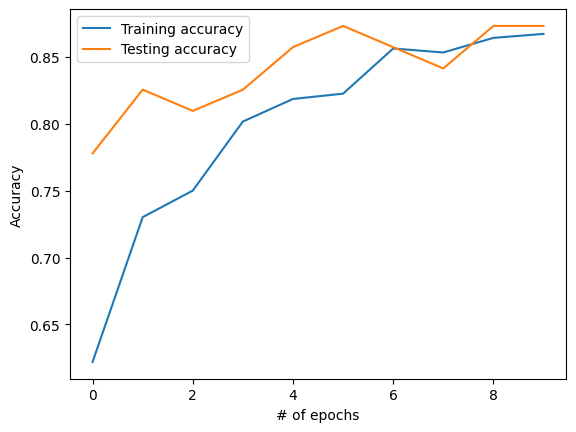

Fine tuning curves


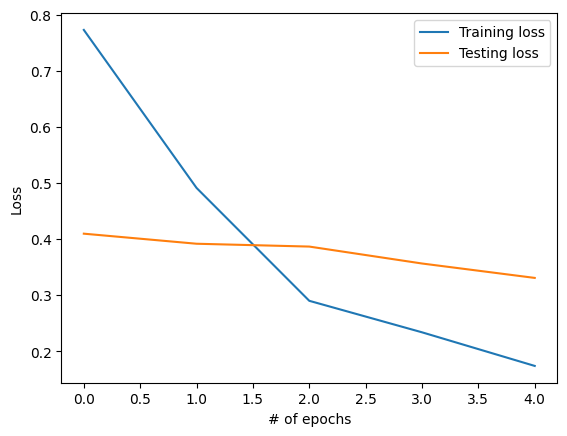

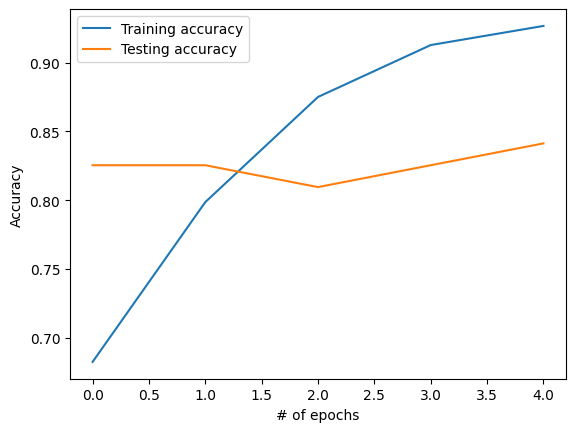

In [111]:
resnet_model.plot_loss_curve()

Set fancy=True to visualise confusion matrix

Before fine tuning set
2/2 [==============================] - 1s 52ms/step


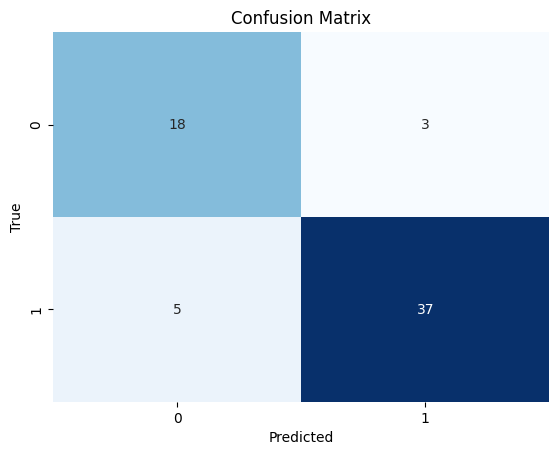

Confusion Matrix:
[[18  3]
 [ 5 37]]
0.873015873015873 0.11904761904761904 0.8769661710838181
After fine tuning set
2/2 [==============================] - 1s 43ms/step


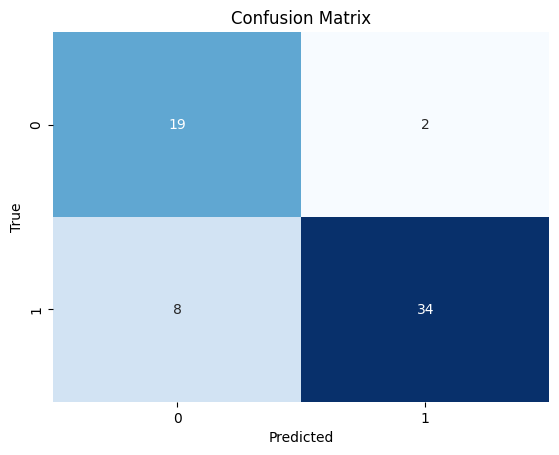

Confusion Matrix:
[[19  2]
 [ 8 34]]
0.8412698412698413 0.19047619047619047 0.825091575091575
Before fine tuning set
1/1 [==============================] - 0s 26ms/step


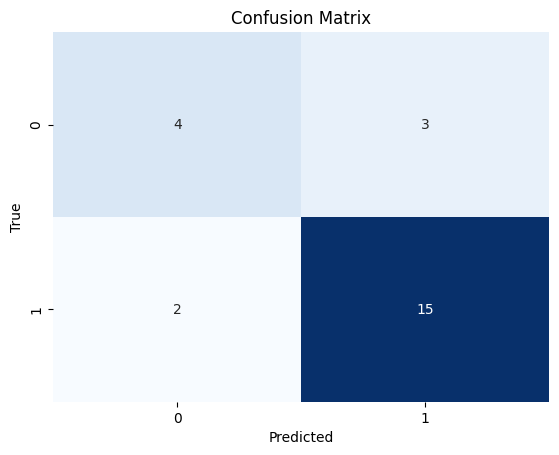

Confusion Matrix:
[[ 4  3]
 [ 2 15]]
0.7916666666666666 0.11764705882352941 0.8345534407027819
After fine tuning set
1/1 [==============================] - 0s 29ms/step


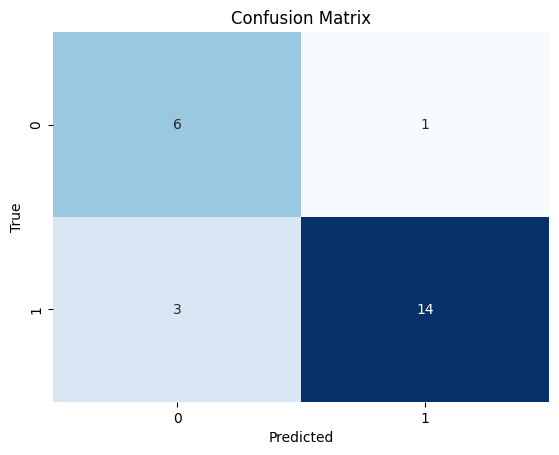

Confusion Matrix:
[[ 6  1]
 [ 3 14]]
0.8333333333333334 0.17647058823529413 0.8284023668639052


In [112]:
# vgg_model.show_confusion_matrix()
# vgg_model.show_confusion_matrix(test_data=(X_test_img_std, X_test_ftr_std, y_test))

# inception_model.show_confusion_matrix()
# inception_model.show_confusion_matrix(test_data=(X_test_img_std, X_test_ftr_std, y_test))

resnet_model.show_confusion_matrix(fancy=True)
resnet_model.show_confusion_matrix(fancy=True, test_data=(X_test_img_std, X_test_ftr_std, y_test))
# resnet_model_wosym.show_confusion_matrix()
# resnet_model_wosym.show_confusion_matrix(test_data=(X_test_img_std, X_test_ftr_std, y_test))

FN
Indices: [ 4  6 10 20 28 48 50 58]


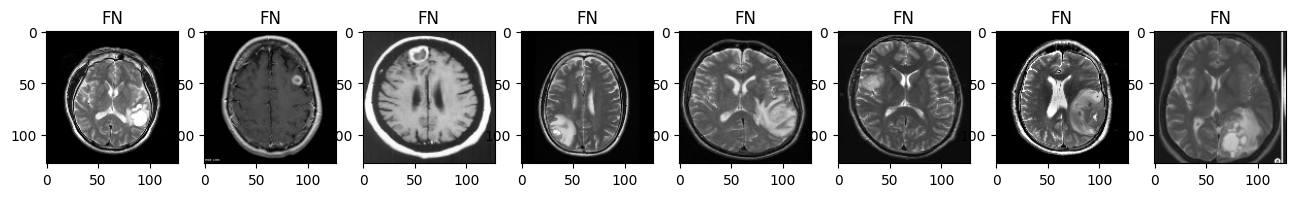

FP
Indices: [ 2 35]


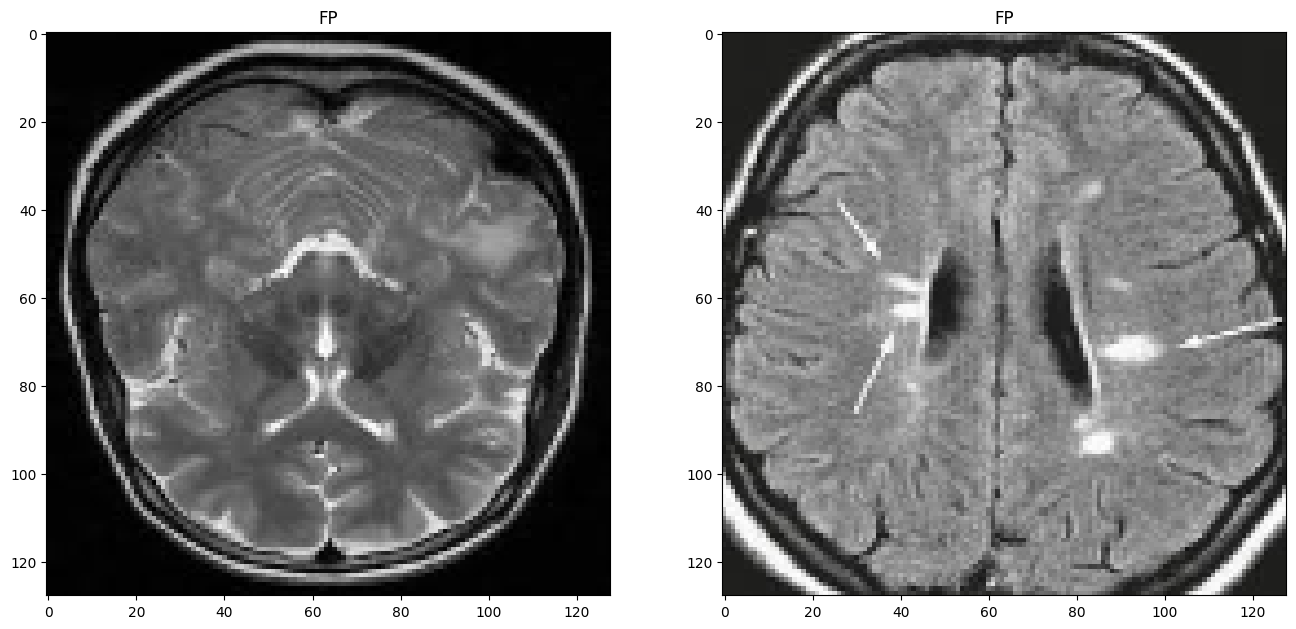

In [113]:
resnet_model.show_misclassified(X_val_img)